## Recommender systems
 In this notebook I will build two recommender systems. 

1.   The first one is to recommend the top 5 movies based on a given movie title.
2.   The second model will estimate the rating of a movie based on the user
behaviour


 

## Agenda 


1.   What is a Recommendation System?
2.   What are the different filtration strategies?
3.   Coding 



### What is a Recommendation System?
Simply put a Recommendation System is a filtration program whose prime goal is to predict the “rating” or “preference” of a user towards a domain-specific item or item. In our case, this domain-specific item is a movie, therefore the main focus of our recommendation system is to filter and predict only those movies which a user would prefer given some data about the user him or herself.

### What are the different filtration strategies?

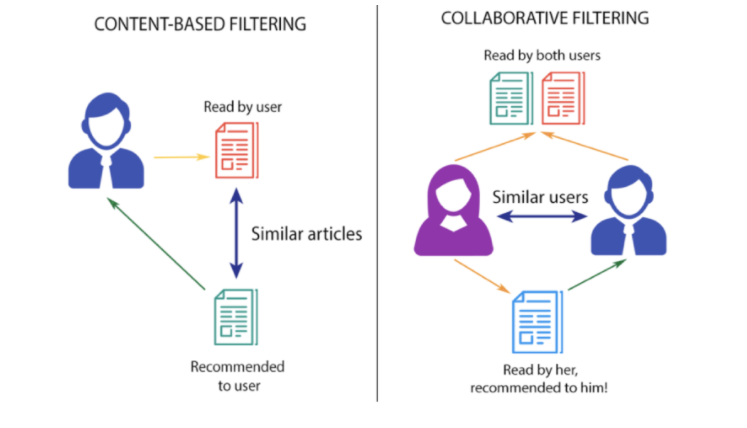

### Let’s start coding up our own Movie recommendation system

## 1 - The first Model

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#  Load the data
movies = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Files/ml-latest-small/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Files/ml-latest-small/ratings.csv")

In [ ]:
#  look at the movies dataset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Here, we can see that userId 1 has watched movieId 1 & 3 and rated both of them 4.0 but has not rated movieId 2 at all. This interpretation is harder to extract from this dataframe. Therefore, to make things easier to understand and work with, we are going to make a new dataframe where each column would represent each unique userId and each row represents each unique movieId.

In [ ]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.5,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.5,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,2.5,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


Now, it’s much easier to interpret that userId 1 has rated movieId 1& 3 4.0 but has not rated movieId 3,4,5 at all (therefore they are represented as NaN ) and therefore their rating data is missing.

Let’s fix this and impute NaN with 0 to make things understandable for the algorithm and also making the data more eye-soothing.

In [ ]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Removing Noise from the data

1. To qualify a movie, a minimum of 10 users should have voted a movie.
2. To qualify a user, a minimum of 50 movies should have voted by the user.



In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count') #Aggregating the number of users who voted -->movieID,number of users who voted
print(no_user_voted)
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')#and the number of movies that were voted -->userID,number of movies that were voted
print(no_movies_voted)

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64
userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64


#### Let’s visualize the number of users who voted with our threshold of 10.

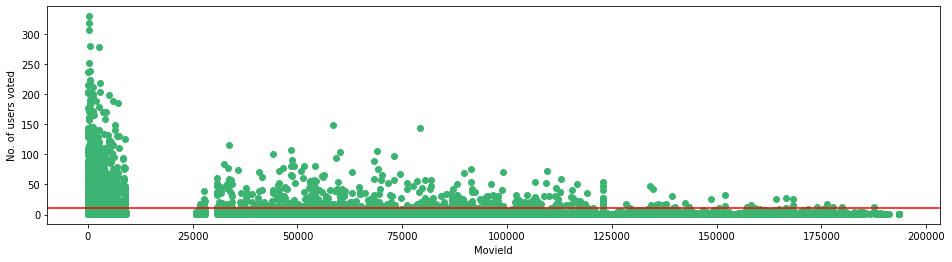

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [ ]:
# Making the necessary modifications as per the threshold set

final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

#### Let’s visualize the number of votes by each user with our threshold of 50

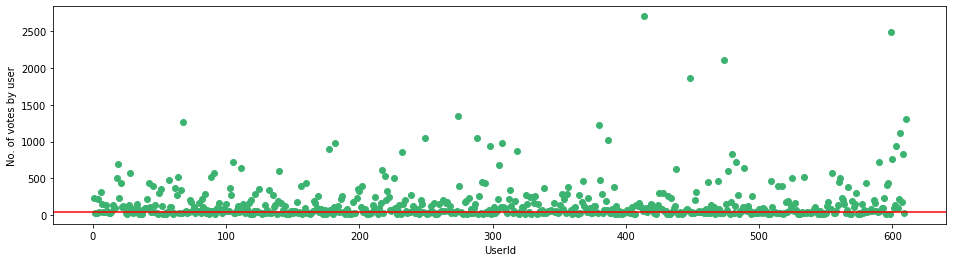

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()


In [ ]:
# Let’s visualize the number of votes by each user with our threshold of 50
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,19,20,21,22,23,24,27,28,29,32,33,34,36,38,39,40,41,42,43,45,47,50,51,52,57,58,59,62,63,64,...,559,560,561,562,563,564,566,567,570,571,572,573,577,579,580,582,583,584,585,586,587,588,590,591,592,593,594,596,597,599,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,4.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,4.0,...,5.0,3.0,4.0,4.5,0.0,0.0,0.0,3.5,4.0,0.0,4.0,5.0,0.0,4.0,3.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.0,0.0,4.0,0.0,2.5,0.0,4.0,0.0,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,3.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.5,0.0,4.5,...,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.5,0.0,3.0,0.0,0.0,0.0,3.0,4.5,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


### Removing sparsity

In [ ]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [ ]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [ ]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)
print(csr_data)
print(final_dataset)


  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (9700, 337)	2.5
  (9701, 337)	3.0
  (9702, 183)	4.0
  (9702, 247)	3.5
  (9703, 317)	2.5
  (9704, 209)	1.0
  (9705, 461)	2.5
  (9706, 49)	3.5
  (9707, 337)	1.5
  (9708, 337)	4.0
  (9709, 337)	1.0
  (9710, 337)	1.5
  (9711, 337)	1.0
  (9712, 337)	1.0
  (9713, 183)	4.5
  (9714, 183)	3.5
  (9715, 183)	3.0
  (9716, 183)	4.0
  (9717, 183)	4.0
  (9718, 183)	3.5
  (9719, 183)	4.0
  (9720, 183)	3.5
  (9721, 183)	3.5
  (9722, 183)	3.5
  (9723, 330)	4.0
userId  movieId    1    2    3    4    5  ...  605  606  607  608  609  610
0             1  4.0  0.0  0.0  0.0  4.0  ...  4.0  2.5  4.0  2.5  3.0  5.0
1             2  0.0  0.0  0.0  0.0  0.0  ... 

### Making the movie recommendation system model

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1) #n_neighborsint > default=5 ,The default metric is minkowski
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 5
    movie_list = movies[movies['title'].str.contains(movie_name)]  # get all movies has the same name from moviesDF --> in dataframe
    print(movie_list['title'])
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId'] # get movieid from moviesDF
        print(movie_idx)
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        print(movie_idx)
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

### Finally, Let’s Recommend some movies!

In [ ]:
get_movie_recommendation('Iron Man')

6743                          Iron Man (2008)
7324                        Iron Man 2 (2010)
8142          Invincible Iron Man, The (2007)
8151                        Iron Man 3 (2013)
9058    Iron Man & Hulk: Heroes United (2013)
9444                          Iron Man (1931)
Name: title, dtype: object
59315
1821


,Title,Distance
1,Avatar (2009),0.310893
2,Iron Man 2 (2010),0.307492
3,WALL·E (2008),0.298138
4,"Dark Knight, The (2008)",0.285835
5,"Avengers, The (2012)",0.285319


## The second model

### with Collaborative Filtering: Matrix Factorization Recommender System

In [ ]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 3.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619393 sha256=f6ecc5cf1ad16a07fdca2d110dbae170a7b9b6bf87a9917f9adb104fb45a1cb9
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# # import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from collections import defaultdict
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV

  ##CrossValidation
from surprise.model_selection import cross_validate


  ##Matrix Factorization Algorithms

from surprise import NMF

### Importing Online Data

In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

r = urlopen("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zipfile = ZipFile(BytesIO(r.read()))

#print the content of zipfile
zipfile.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/tags.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/movies.csv']

In [ ]:
# tidy df ratings (movieId,)
ratings_df = pd.read_csv(zipfile.open('ml-latest-small/ratings.csv'))
print('Columns of ratings_df: {0}'.format(ratings_df.columns))

#movies df (tidy data)
movies_df = pd.read_csv(zipfile.open('ml-latest-small/movies.csv'))
print('Columns of movies_df: {0}'.format(movies_df.columns))

Columns of ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Columns of movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


### Inspecting the Data

In [ ]:
print(ratings_df.head())


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [ ]:
print(ratings_df.describe())

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [ ]:
print(movies_df.head())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]


### Data Pre-Processing
Filtering Data Set

In [ ]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 #a user rated movies at least


ratings_flrd_df = ratings_df.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)


'3446 movies deleted; all movies are now rated at least: 2 times. Old dimensions: (100836, 4); New dimensions: (97390, 4)'

### Data Loading with Surprise

In [ ]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(ratings_flrd_df[["userId",	"movieId",	"rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()

### Non-Negative Matrix Factorization (NMF)

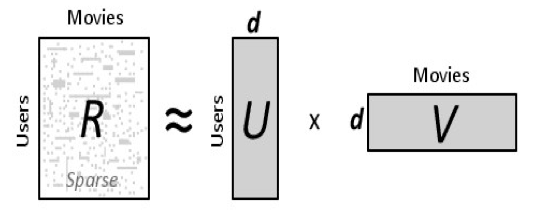

In [ ]:
algo_NMF = NMF(n_factors = 16)
algo_NMF.fit(trainset)


# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo_NMF.test(testset)

In [ ]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

In [ ]:
hist_NMF_124, pred_NMF_124 = get_top_n(predictions, movies_df = movies_df, userId = 124, ratings_df = ratings_df)

User 124 has already rated 50 movies.


In [ ]:
pred_NMF_124

,userId,movieId,rat_pred,title,genres
0,124,954,5.0,Mr. Smith Goes to Washington (1939),Drama
1,124,1208,5.0,Apocalypse Now (1979),Action|Drama|War
2,124,2959,5.0,Fight Club (1999),Action|Crime|Drama|Thriller
3,124,1734,5.0,My Life in Pink (Ma vie en rose) (1997),Comedy|Drama
4,124,3083,5.0,All About My Mother (Todo sobre mi madre) (1999),Drama
5,124,71899,5.0,Mary and Max (2009),Animation|Comedy|Drama
6,124,112421,5.0,Frank (2014),Comedy|Drama|Mystery
7,124,177593,5.0,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
8,124,2936,5.0,Sullivan's Travels (1941),Adventure|Comedy|Romance
9,124,3451,5.0,Guess Who's Coming to Dinner (1967),Drama
